# Sample Code for Testing Saved Model
This file provides a sample to test the saved model. Make necessary changes so that we can test your MLP model with this file. 

## Load test data
In the sample below, it loads the dev set for testing. But in real marking, the markers will load held-out test set.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# read data
import pandas as pd

dev_data = pd.read_csv('/content/drive/MyDrive/cw2_dev.csv')
dev_data

,Unnamed: 0,Sent1,Sent2,SimScore
0,0,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.,1.00
1,1,A young child is riding a horse.,A child is riding a horse.,0.95
2,2,A man is feeding a mouse to a snake.,The man is feeding a mouse to the snake.,1.00
3,3,A woman is playing the guitar.,A man is playing guitar.,0.48
4,4,A woman is playing the flute.,A man is playing a flute.,0.55
...,...,...,...,...
2995,2995,"The professor introduced the artists , and the...",The professor introduced the artists .,0.62
2996,2996,The doctors supported the judges .,The doctors supported the tourists and the jud...,0.68
2997,2997,The secretary knew the manager .,The secretary knew the manager danced .,0.37
2998,2998,The professors next to the president recommend...,The president recommended the professors .,0.29


## Load Embeddings
Clearly specify the embeddings your implementation requires. Also provide the link for downloading the embeddings. 

In [44]:
# load pre-trained glove embeddings
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import numpy as np

embd_name = 'glove.840B.300d'
link_to_embd = 'http://nlp.stanford.edu/data/glove.840B.300d.zip' # TODO: you should provide the link to download the embedding here

# Below is a sample to load the glove embeddings. ADJUST the code according to the
# embedding you want to use. 
word_vec_dim = 300
path_of_downloaded_files = "/content/drive/MyDrive/glove.840B.{}d.txt".format(word_vec_dim)
glove_file = datapath(path_of_downloaded_files)
word2vec_glove_file = get_tmpfile("glove.840B.300d.txt")
glove2word2vec(glove_file, word2vec_glove_file)
word_vectors = KeyedVectors.load_word2vec_format(word2vec_glove_file)



## Provide Functions Needed for Evaluation
All functions used to run and evaluate your model should be provided. 

In [58]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from nltk.tokenize import word_tokenize
import numpy as np

embd_dim = 300
dropout = 0.2

def get_sent_word_vecs(word_vectors, sent_words, largest_len):
    vecs = []
    for ww in sent_words:
        if ww in word_vectors:
            vecs.append(word_vectors[ww])
        else:
            vecs.append(oov_vec)

    for i in range(largest_len-len(sent_words)):
        vecs.append([0.]*embd_dim)
    return np.array(vecs)

def build_mini_batch(sent_list_1,sent_list_2, word_vectors):
    tokenized_sents_1 = [word_tokenize(ss.lower()) for ss in sent_list_1]
    tokenized_sents_2 = [word_tokenize(ss.lower()) for ss in sent_list_2]
    largest_len_1 = np.max([len(tokens) for tokens in tokenized_sents_1])
    largest_len_2 = np.max([len(tokens) for tokens in tokenized_sents_2])
    largest_len = np.max([largest_len_1,largest_len_2])
    text_vecs_1 = []
    text_vecs_2 = []
    for ts in tokenized_sents_1:
        vv = get_sent_word_vecs(word_vectors, ts, largest_len)
        text_vecs_1.append(vv)
    for ts in tokenized_sents_2:
        vv = get_sent_word_vecs(word_vectors, ts, largest_len)
        text_vecs_2.append(vv) 
    return np.array(text_vecs_1),np.array(text_vecs_2)

def make_batch_prediction(sent_list, word_vectors, model):
    batch_1,batch_2 = build_mini_batch(sent_list[:,0],sent_list[:,1], word_vectors)
    batch_vals_1 = torch.tensor([])
    batch_vals_2 = torch.tensor([])
    for i in range(batch_1.shape[0]):
        input_sents_1 = torch.from_numpy(batch_1[i]).float()
        input_sents_2 = torch.from_numpy(batch_2[i]).float()
        vals_1,vals_2 = model(input_sents_1.unsqueeze(0),input_sents_2.unsqueeze(0))
        batch_vals_1 = torch.cat( (batch_vals_1, vals_1) )
        batch_vals_2 = torch.cat( (batch_vals_2, vals_2) )
    return batch_vals_1.view(batch_1.shape[0],-1), batch_vals_2.view(batch_2.shape[0],-1)


def evaluate_trained_model(trained_model, dev_data):
    test_docs = dev_data[['Sent1','Sent2']].to_numpy()
    test_labels = dev_data['SimScore'].to_numpy()
    cos_sim = nn.CosineSimilarity(dim =2)
    with torch.no_grad(): # let pytorch know that no gradient should be computed
        model.eval() # let the model know that it in test mode, i.e. no gradient and no dropout        
        sent1_repr, sent2_repr = make_batch_prediction(
            test_docs, word_vectors, trained_model)
        y_pred = cos_sim(sent1_repr.unsqueeze(0),sent2_repr.unsqueeze(0))
        y_target = torch.tensor([test_labels], dtype=torch.float).squeeze()
        squared_errors = [np.square(ts-ps) for (ts, ps) in zip(y_pred.detach().numpy(), y_target.unsqueeze(0).detach().numpy())]
        abs_errors = [np.abs(ts-ps) for (ts, ps) in zip(y_pred.detach().numpy(), y_target.unsqueeze(0).detach().numpy())]                                                   

    print('MSE of the method on the dev set:', np.mean(squared_errors))

    # check the distribution (histo gram) of the squared errors and absolute errors
    plt.hist(squared_errors)
    plt.figure()
    plt.hist(abs_errors)

## Provide Your Model
You should provide the implementaiton of your encoder model below.

In [56]:
# define the baseline model
import numpy as np
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, embd_dim,dropout):
        super(MLP, self).__init__()
        self.relu = nn.ReLU()          #two layers of same size worked well in the past
        self.fully_connected_layer_1 = nn.Linear(embd_dim, 400)
        self.fully_connected_layer_2 = nn.Linear(400, 350)
        self.fully_connected_layer_3 = nn.Linear(350, 300)
        self.dropout = nn.Dropout(dropout)
        

        
    def forward(self, sent1_vecs, sent2_vecs):
    
        A0_first = torch.mean(torch.FloatTensor(sent1_vecs), dim=0).unsqueeze(0)
        A0_second = torch.mean(torch.FloatTensor(sent2_vecs), dim=0).unsqueeze(0)
        A1_first  = self.dropout(self.relu(self.fully_connected_layer_1(A0_first)))
        A1_second  = self.dropout(self.relu(self.fully_connected_layer_1(A0_second)))
        A2_first = self.relu(self.fully_connected_layer_2(A1_first))
        A2_second = self.relu(self.fully_connected_layer_2(A1_second))
        sent1_repr = self.relu(self.fully_connected_layer_3(A2_first))
        sent2_repr = self.relu(self.fully_connected_layer_3(A2_second))

        
        return sent1_repr, sent2_repr

## Run and Evaluate Model
The code below creates an instance of the model, loads the saved weights (sample_model.state_dict; run cw2_sample.ipynb will generate this file), and tests it.

In [4]:
cd '/content/drive/MyDrive/'

/content/drive/MyDrive


In [15]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

MSE of the method on the dev set: 0.061450418


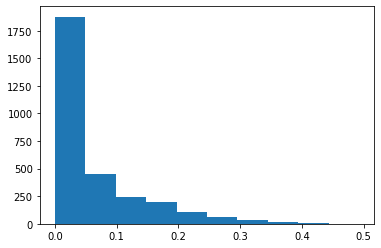

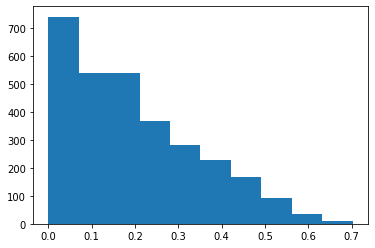

In [59]:
import pickle

# load the saved file
with open('best_mlp.state_dict','rb') as ff:
    saved_info = pickle.load(ff)

# extract the information from the saved file
oov_vec = saved_info['oov_vec']
saved_model_state = saved_info['model_state_dict']

# create model, load saved weights, and test the model
model = MLP(embd_dim=word_vec_dim,dropout= dropout)
model.load_state_dict(saved_model_state) 
evaluate_trained_model(model, dev_data)
